/tmp/ipykernel_6923/4125654254.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].median(), inplace=True)
/tmp/ipykernel_6923/4125654254.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Random Forest Mean ROC AUC Score for xyz_vaccine: 0.8272137594447588
XGBoost Mean ROC AUC Score for xyz_vaccine: 0.8237060967969798
Best model for xyz_vaccine: Random Forest


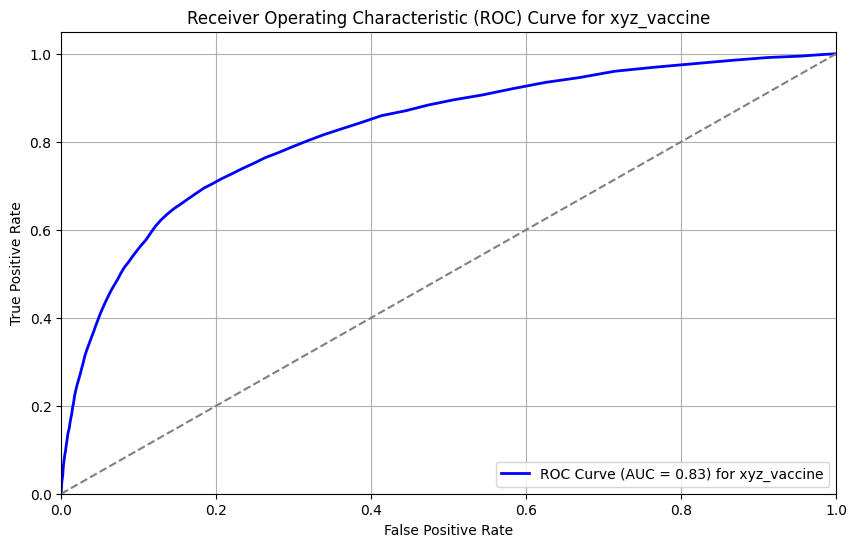

/home/teju/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Random Forest Mean ROC AUC Score for seasonal_vaccine: 0.850040442485575
XGBoost Mean ROC AUC Score for seasonal_vaccine: 0.849063891281172
Best model for seasonal_vaccine: Random Forest


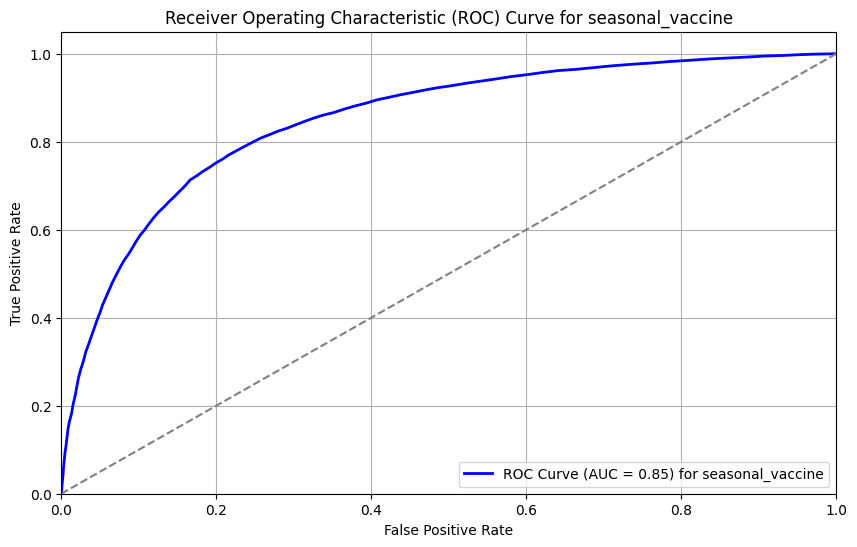

In [5]:
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def custom_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred, average='macro')

train_data = pd.read_csv('training_set_features.csv')
test_data = pd.read_csv('test_set_features.csv')
train_label = pd.read_csv('training_set_labels.csv')

train_data = pd.merge(train_data, train_label, on='respondent_id')

for col in train_data.columns:
    if col in train_label.columns: 
        continue
    if train_data[col].dtype == 'object':
        train_data[col].fillna(train_data[col].mode()[0], inplace=True)
        test_data[col].fillna(test_data[col].mode()[0], inplace=True)
    else:
        train_data[col].fillna(train_data[col].median(), inplace=True)
        test_data[col].fillna(test_data[col].median(), inplace=True)

categorical_columns = [
    'age_group', 'education', 'race', 'sex', 'income_poverty',
    'marital_status', 'rent_or_own', 'employment_status', 
    'hhs_geo_region', 'census_msa', 'employment_industry', 
    'employment_occupation'
]

def process_vaccine(vaccine_target):
    feature_columns = [
        'xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
        'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 
        'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_xyz', 
        'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 
        'health_worker', 'health_insurance', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
        'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
        'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex', 'income_poverty',
        'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 
        'household_adults', 'household_children', 'employment_industry', 'employment_occupation'
    ]

    combined_data = pd.concat([train_data[categorical_columns], test_data[categorical_columns]], axis=0)

    le = LabelEncoder()
    for col in categorical_columns:
        combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    
    train_data[categorical_columns] = combined_data[:len(train_data)][categorical_columns]
    test_data[categorical_columns] = combined_data[len(train_data):][categorical_columns]
    
    X_train = train_data[feature_columns]
    y_train = train_data[vaccine_target]
    
    rf = RandomForestClassifier()
    xgb = XGBClassifier()
    
    scorer = make_scorer(roc_auc_score, needs_proba=True)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rf_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=scorer)
    xgb_scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=scorer)
    
    print(f"Random Forest Mean ROC AUC Score for {vaccine_target}: {rf_scores.mean()}")
    print(f"XGBoost Mean ROC AUC Score for {vaccine_target}: {xgb_scores.mean()}")
    
    best_model = rf if rf_scores.mean() > xgb_scores.mean() else xgb
    print(f"Best model for {vaccine_target}: {'Random Forest' if best_model == rf else 'XGBoost'}")
    
    best_model.fit(X_train, y_train)
    
    X_test = test_data[feature_columns]
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    y_train_pred_proba = cross_val_predict(best_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_proba)
    roc_auc = roc_auc_score(y_train, y_train_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f}) for {vaccine_target}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {vaccine_target}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return y_pred_proba

y_pred_proba_xyz = process_vaccine('xyz_vaccine')
y_pred_proba_seasonal = process_vaccine('seasonal_vaccine')

submission = pd.DataFrame({
    'respondent_id': test_data['respondent_id'],
    'xyz_vaccine': y_pred_proba_xyz,
    'seasonal_vaccine': y_pred_proba_seasonal
})

submission.to_csv('submission.csv', index=False)


Range of 'xyz_vaccine' probabilities:
count    26708.000000
mean         0.219459
std          0.201782
min          0.000000
25%          0.070000
50%          0.150000
75%          0.310000
max          0.980000
Name: xyz_vaccine, dtype: float64
Range of 'seasonal_vaccine' probabilities:
count    26708.000000
mean         0.467499
std          0.279576
min          0.000000
25%          0.210000
50%          0.450000
75%          0.720000
max          1.000000
Name: seasonal_vaccine, dtype: float64
All probabilities are within the valid range [0, 1].

Sample rows from the submission file:
   respondent_id  xyz_vaccine  seasonal_vaccine
0          26707         0.18              0.33
1          26708         0.04              0.07
2          26709         0.58              0.76
3          26710         0.53              0.90
4          26711         0.25              0.45


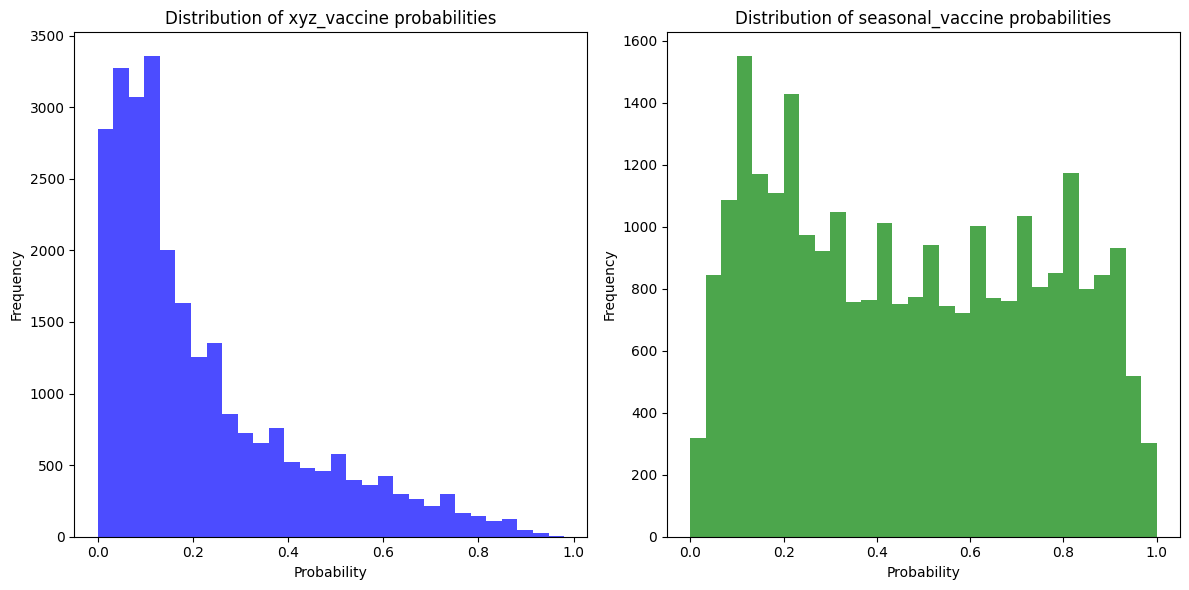

In [6]:
import pandas as pd

submission = pd.read_csv('submission.csv')

print("Range of 'xyz_vaccine' probabilities:")
print(submission['xyz_vaccine'].describe())

print("Range of 'seasonal_vaccine' probabilities:")
print(submission['seasonal_vaccine'].describe())

xyz_valid = submission['xyz_vaccine'].between(0, 1).all()
seasonal_valid = submission['seasonal_vaccine'].between(0, 1).all()

if xyz_valid and seasonal_valid:
    print("All probabilities are within the valid range [0, 1].")
else:
    print("Some probabilities are out of the valid range [0, 1].")

print("\nSample rows from the submission file:")
print(submission.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(submission['xyz_vaccine'], bins=30, alpha=0.7, color='blue')
plt.title('Distribution of xyz_vaccine probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(submission['seasonal_vaccine'], bins=30, alpha=0.7, color='green')
plt.title('Distribution of seasonal_vaccine probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()